In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [94]:
plt.style.use('seaborn-v0_8-darkgrid')
data = pd.read_csv('../../data/BrentOilPrices.csv')
print(data.head())
print(data.info())

        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
None


In [95]:
print(data.dtypes)

Date      object
Price    float64
dtype: object


In [96]:
data['Date'] = pd.to_datetime(data['Date'])  

/var/folders/b3/zdl2xxh53jgc4hjrq6hk1p9c0000gn/T/ipykernel_16470/2783472425.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [97]:
print(data.dtypes)
print(data.head())

Date     datetime64[ns]
Price           float64
dtype: object
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


In [98]:
data.set_index('Date', inplace=True)

In [99]:
print(data.head())

            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


In [100]:
print(data.isnull().sum())

Price    0
dtype: int64


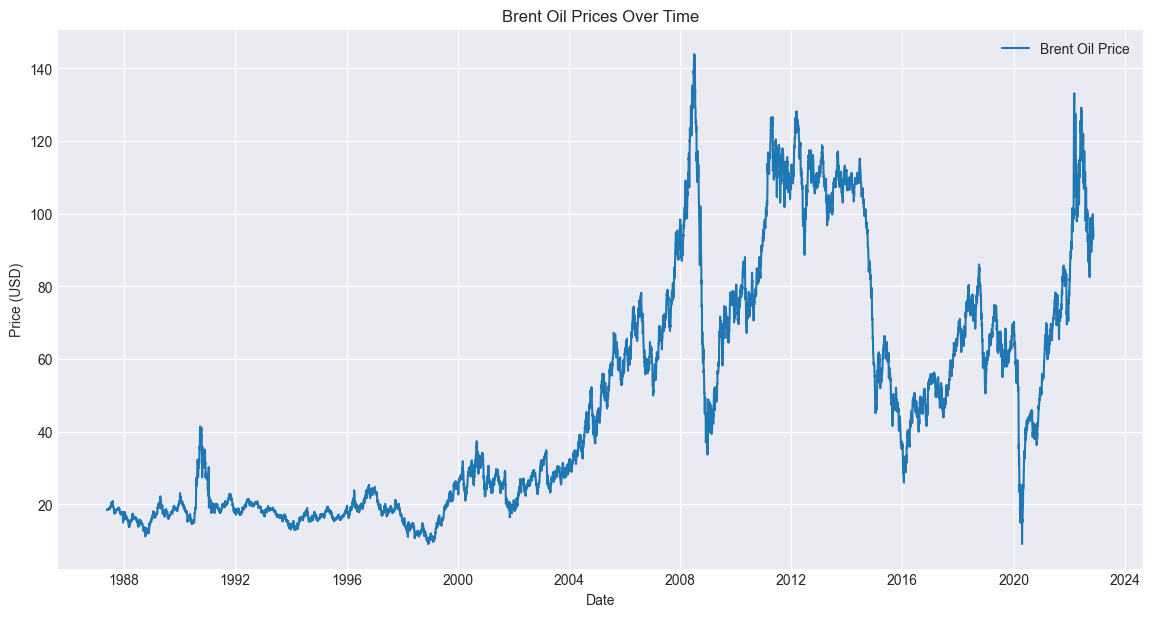

             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


In [101]:
# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(data['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Check basic statistics
print(data.describe())


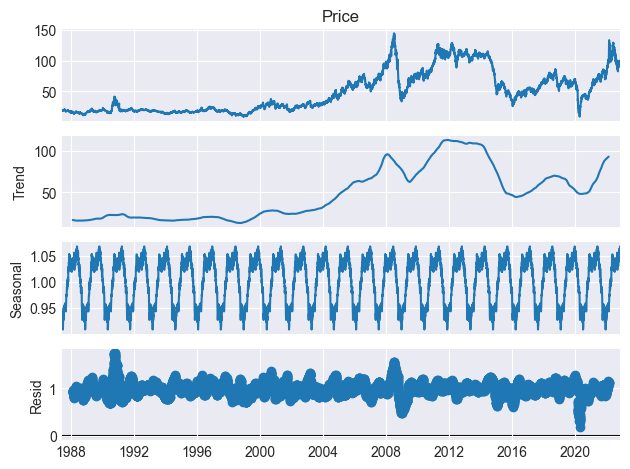

In [102]:
    # Decompose the time series to observe trend, seasonality, and residual components.
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(data['Price'], model='multiplicative', period=365)
decomposition.plot()
plt.show()


In [103]:
# For time series models like ARIMA, the data needs to be stationary. Perform the Augmented Dickey-Fuller (ADF) test to check stationarity.
# Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')

adf_test(data['Price'])


ADF Statistic: -1.9938560113924644
p-value: 0.2892735048934042
Critical Value 1%: -3.4310783342658615
Critical Value 5%: -2.861861876398633
Critical Value 10%: -2.566941329781918


In [104]:
# Differencing to make the series stationary
data['Price_diff'] = data['Price'].diff().dropna()

# Re-check stationarity
adf_test(data['Price_diff'].dropna())


ADF Statistic: -15.529367580048005
p-value: 2.2307405105164086e-28
Critical Value 1%: -3.4310783342658615
Critical Value 5%: -2.861861876398633
Critical Value 10%: -2.566941329781918


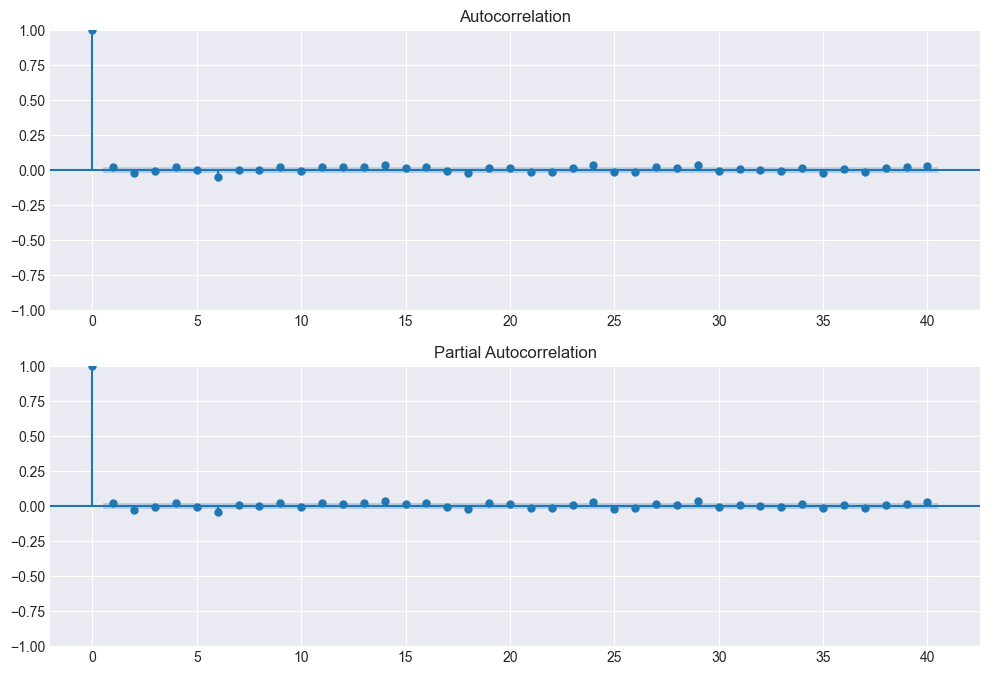

In [105]:
# Plot ACF and PACF for differenced series
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['Price_diff'].dropna(), ax=ax[0], lags=40)
plot_pacf(data['Price_diff'].dropna(), ax=ax[1], lags=40)
plt.show()


/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Tue, 05 Nov 2024   AIC                          29093.899
Time:                        18:19:51   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

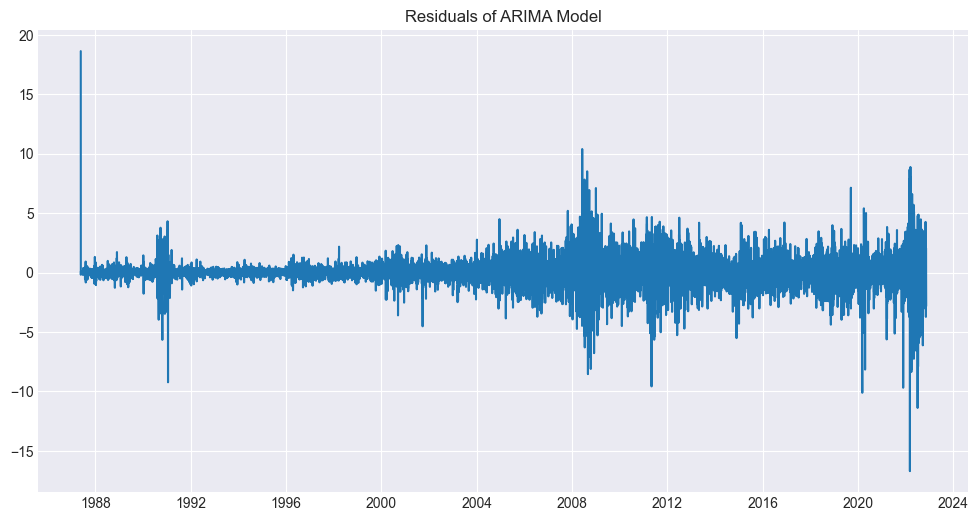

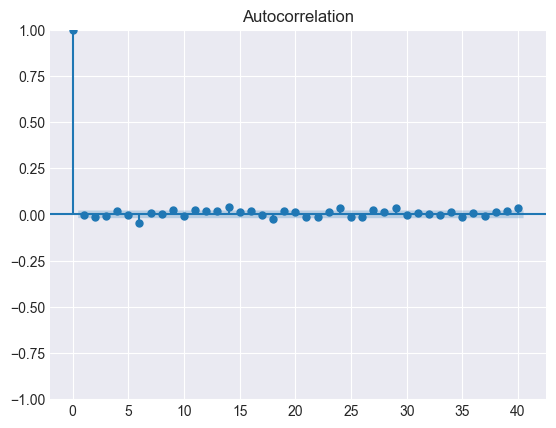

In [106]:
# Fit ARIMA model
model = ARIMA(data['Price'], order=(1, 1, 1))
arima_result = model.fit()

# Summary of the model
print(arima_result.summary())

# Plot the residuals to check for white noise
residuals = arima_result.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# ACF of residuals
plot_acf(residuals, lags=40)
plt.show()


/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/junior/Documents/Tenx/Birhan_Energies/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


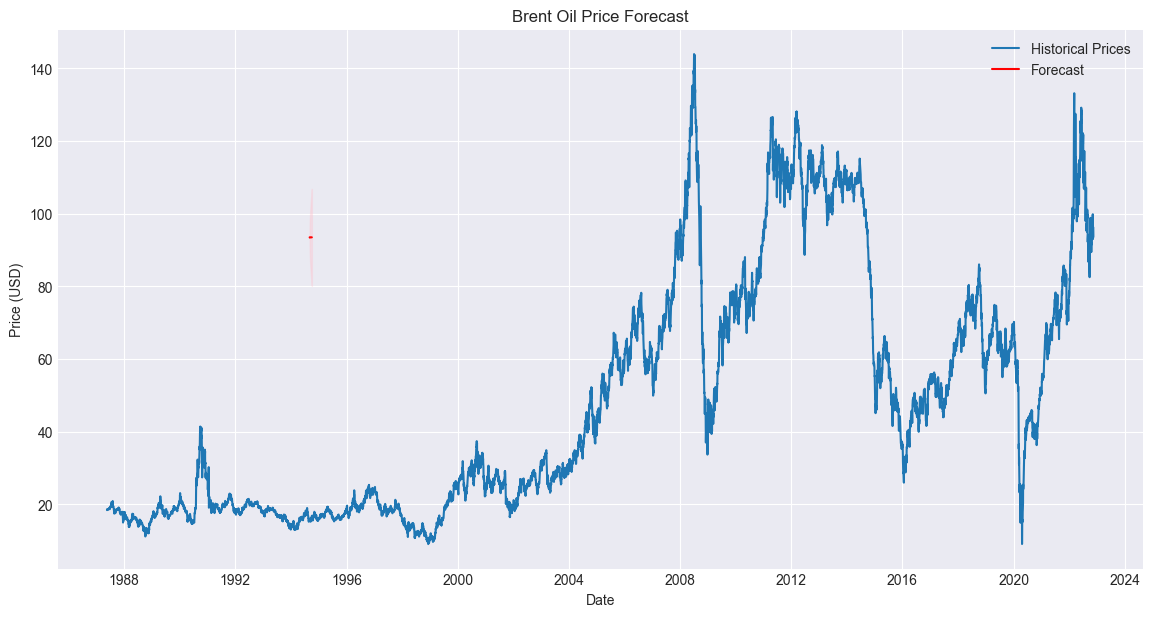

In [107]:
# Forecast for the next 30 days
forecast = arima_result.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

# Plot forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(data['Price'], label='Historical Prices')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Brent Oil Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [108]:
# Save the residuals and forecast data to CSV files for reporting
residuals.to_csv('../../data/residuals.csv')
forecast_df = forecast.predicted_mean.to_frame(name='Forecast')
forecast_df.to_csv('../../data/forecast.csv')
